In [1]:
# !pip3 install matplotlib pandas seaborn
%matplotlib inline

In [2]:
import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

In [3]:
from databuddy import get_data, get_votes, get_states

In [4]:
def construct_dataframe():

    data = get_data()
    states = get_states()
    votes2020 = get_votes(2020)

    # Remove states that have no data
    data = data[data.state.isin(states.index)]


    data["state_popn"] = data.state.map(lambda s: states.loc[s].Pop)
    data["state_name"] = data.state.map(lambda s: states.loc[s].State)
    
    # Remove states that aren't in the votes data
    data = data[data.state_name.str.upper().isin(votes2020.state)]

    votes2020 = votes2020.set_index("state")
    
    data["state_dem_votes"] = data.state_name.map(lambda s: votes2020.loc[s.upper().strip()].candidatevotes.DEMOCRAT)
    data["state_rep_votes"] = data.state_name.map(lambda s: votes2020.loc[s.upper().strip()].candidatevotes.REPUBLICAN)
    data["test_pos_state_popn"] = 100*data.tot_cases / data.state_popn
    data["new_case_state_popn"] = 100*data.new_case / data.state_popn
    data["death_pct_state_popn"] = 100*data.tot_death / data.state_popn

    return data

In [5]:
data = construct_dataframe()

data["political_affiliation"] = data.state_dem_votes > data.state_rep_votes
data["political_affiliation"] = data.political_affiliation.map(lambda x: "D" if x else "R")

/var/folders/xb/l415c7qx7dz0d895wpxs4sc00000gp/T/ipykernel_7403/2081616629.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["state_popn"] = data.state.map(lambda s: states.loc[s].Pop)
/var/folders/xb/l415c7qx7dz0d895wpxs4sc00000gp/T/ipykernel_7403/2081616629.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["state_name"] = data.state.map(lambda s: states.loc[s].State)


In [6]:
votes2020 = get_votes(2020)
votes2020.candidatevotes.sum()
votes2020['percD'] = [r.candidatevotes.DEMOCRAT / r.candidatevotes.sum() for i, r in votes2020.iterrows()]
votes2020['percR'] = [r.candidatevotes.REPUBLICAN / r.candidatevotes.sum() for i, r in votes2020.iterrows()]
states = get_states().reset_index()
votes2020 = votes2020[votes2020.state != "DISTRICT OF COLUMBIA"]
votes2020['state_abbr'] = (
    votes2020.state.map(lambda x: states[states.State.str.upper() == x.upper()].iloc[0].Postalcode)
)
votes2020['Pop'] = (
    votes2020.state.map(lambda x: states[states.State.str.upper() == x.upper()].iloc[0].Pop)
)

votes2020 = votes2020.set_index("state_abbr")

/var/folders/xb/l415c7qx7dz0d895wpxs4sc00000gp/T/ipykernel_7403/116820628.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  votes2020['state_abbr'] = (
/var/folders/xb/l415c7qx7dz0d895wpxs4sc00000gp/T/ipykernel_7403/116820628.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  votes2020['Pop'] = (


In [7]:
# STATES = ["MD", "PA", "AL", "TX", "ND", "NY"]
STATE_COLORS = {
    # Nice hex colors spanning the spectrum
    "MD": "#8c564b",
    "PA": "#e377c2",
    "AL": "#7f7f7f",
    "TX": "#bcbd22",
    "ND": "#17becf",
    "NY": "#1f77b4",
    "FL": "#ff7f0e",
    "NJ": "#2ca02c",
}
 

In [8]:
len(data)

36650

In [9]:
data = data[~pd.isna(data.tot_cases) & data.tot_cases > 0]

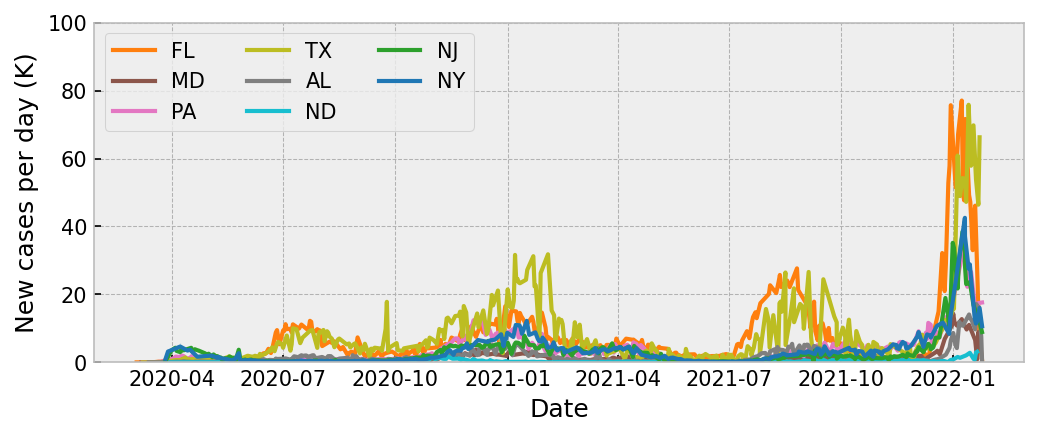

In [10]:
_plotting_data = data[data.state.isin(STATE_COLORS)]
_plotting_data = _plotting_data[_plotting_data.new_case > 0.001].reset_index()

with plt.style.context("bmh"):
    plt.figure(figsize=(8, 3), dpi=150)

    sns.lineplot(
        y='new_case',
        x='created_at',
        data=_plotting_data,
        hue="state",
        palette=STATE_COLORS,
    )
#     plt.yscale("log")
    leg = plt.legend(ncol=3)
    plt.yticks(plt.yticks()[0], [str(int(x/1000)) for x in plt.yticks()[0]])
    plt.ylim(0, max(plt.ylim()))
    plt.ylabel("New cases per day (K)")
    plt.xlabel("Date")

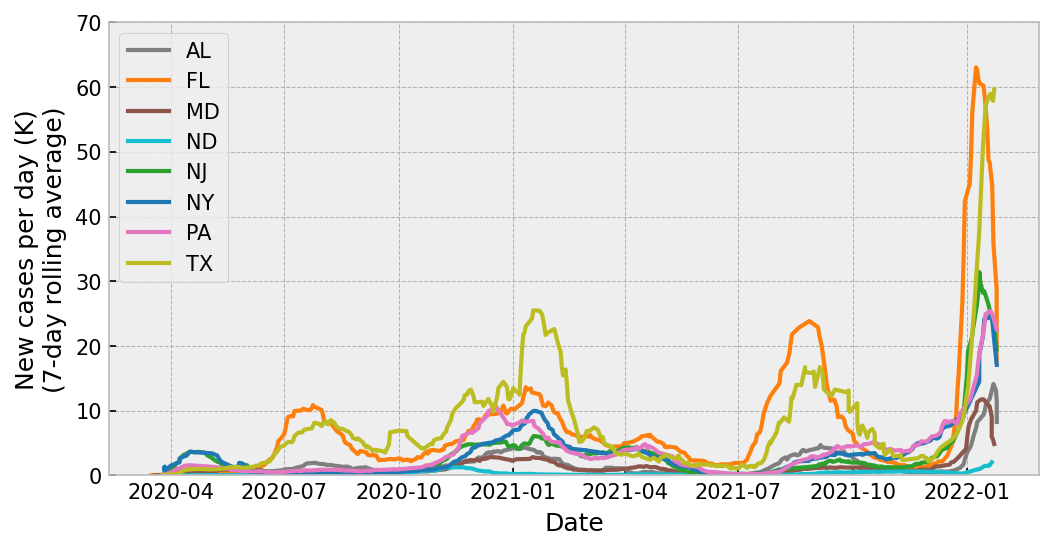

In [11]:
with plt.style.context("bmh"):
    fig, ax = plt.subplots(figsize=(8, 4), dpi=150)

    groups = _plotting_data.groupby('state')
    for k in sorted(STATE_COLORS.keys()):
        v = groups.get_group(k)
        # X is date
        # Y is rolling average of new cases over last 7 days
        X = v.created_at.values
        Y = v.new_case.rolling(7).mean().values
        ax.plot(X, Y, label=k, color=STATE_COLORS[k])

    plt.ylabel("New cases per day (K)\n(7-day rolling average)")
    # set y ticks to be in thousands (K)
    plt.yticks(plt.yticks()[0], [str(int(x/1000)) for x in plt.yticks()[0]])
    plt.ylim(0, max(plt.ylim()))
    plt.xlabel("Date")
    plt.legend(loc='upper left')


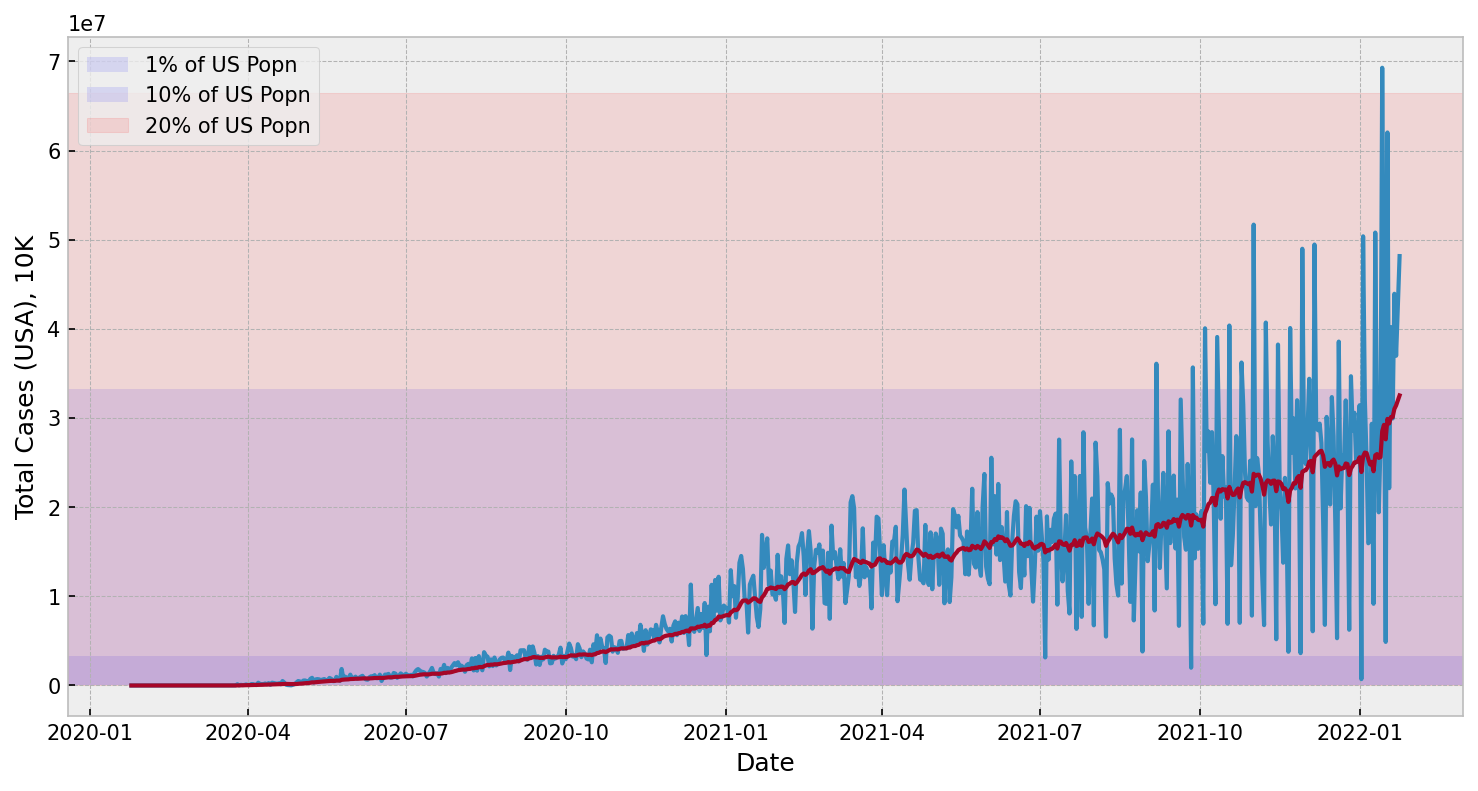

In [12]:
_d = data.groupby(data.created_at.dt.date).sum()

POPN_ESTIMATE = 332_000_000

with plt.style.context("bmh"):
    plt.figure(figsize=(12, 6), dpi=150)
    sns.lineplot(x='created_at', y=_d.tot_cases, data=_d, )
    sns.lineplot(x='created_at', y=_d.tot_cases.ewm(14).mean(), data=_d)
    plt.xlabel("Date")
    plt.ylabel("Total Cases (USA), 10K")
    
    plt.axhspan(0, POPN_ESTIMATE*0.01, alpha=0.1, label="1% of US Popn")
    plt.axhspan(0, POPN_ESTIMATE*0.1, alpha=0.1, label="10% of US Popn")
    plt.axhspan(0, POPN_ESTIMATE*0.2, alpha=0.1, color='r', label="20% of US Popn")
    plt.legend()
#     plt.yscale("log")

In [13]:
# It's Cute Little Animation Time, Folks!

OUTPUT_PATH = "animation/polarization/"
!mkdir -p {OUTPUT_PATH}
import numpy as np

LABEL_DISTANCE_THRESHOLD = 0.7

# set mpl font to helv:
plt.rcParams['font.family'] = 'Helvetica'
# and bold:
plt.rcParams['font.weight'] = 'bold'
def plot_data_until_date(data, datestr: str, plot_percentages=True):
    date = pd.to_datetime(datestr)
    _plottable_data = data[data.created_at < date]
    with plt.style.context("bmh"):
        plt.figure(figsize=(5, 4), dpi=150)
        plt.gca().set_facecolor("#dedede")
        if plot_percentages:
            pstm = _plottable_data.groupby("state").test_pos_state_popn.max().sort_values()
            xs = pstm.index.map(lambda x: votes2020.loc[x].percR*100)
            ys = pstm
            labels = pstm.index
            cs = pstm.index.map(lambda x: votes2020.loc[x].percD*100)
        else:
            pstm = _plottable_data.groupby("state").tot_cases.max().sort_values()
            xs = pstm.index.map(lambda x: votes2020.loc[x].percR*100)
            ys = pstm
            labels = pstm.index
            cs = pstm.index.map(lambda x: votes2020.loc[x].percD*100)
        plt.scatter(
            xs,
            ys,
            c=cs,
            # cmap='RdBu',
            cmap=matplotlib.colors.LinearSegmentedColormap.from_list(
                "my_colormap",
                [(0, "red"), (0.5, "purple"), (1, "blue")],
                N=256
            ),
            marker='o', 
            # s=[
            #     votes2020.loc[_plottable_data.groupby("state").test_pos_state_popn.max().sort_values().index].Pop/20000
            # ], 
            s=120,
            alpha=0.8
        )
        # add labels:
        for x, y, label in zip(xs, ys, labels):
            x = float(x)
            y = float(y)
            # only render if the label has a distance from the other points.
            dists = np.zeros(len(xs), dtype=float) + 999
            for i, (x2, y2) in enumerate(zip(xs, ys)):
                x2 = float(x2)
                y2 = float(y2)
                if x2 == x and y2 == y:
                    continue
                dists[i] = np.sqrt((x-x2)**2 + (y-y2)**2)
            if dists.min() > LABEL_DISTANCE_THRESHOLD:
                plt.text(
                    x, y, label, fontsize=6, 
                    # white text:
                    color='white',
                    # bold:
                    weight='bold',
                    horizontalalignment='center', verticalalignment='center'
                )
        plt.xlim(50-25, 50+25)
        # if plot_percentages:
        #     plt.ylim(0, 25)
        plt.xlabel("Political Affiliation (by vote %)")
        if plot_percentages:
            plt.ylabel("% of state population\nwith +COVID-19 test")
        else:
            plt.ylabel("Total Cases (by state)")
        plt.xticks([30, 50, 70], ["Lean Dem (20%)", "50/50", "Lean Rep (20%)"])
        plt.title(datestr)
        plt.savefig(
            f"{OUTPUT_PATH}/{date.strftime('%Y-%m-%d')}.png", 
            dpi=150, bbox_inches='tight',
            facecolor='#efefef',
        )
        plt.close()

from datetime import timedelta

def animate_plot_data_until_date(
        data, 
        start_date: str = "2020-04-01", 
        end_date: str = "2020-05-01",
        day_delta: int = 14, parallel=False,
        plot_percentages=True):
    date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    if not parallel:
        while date < end_date:
            plot_data_until_date(data, date.strftime("%Y-%m-%d"), plot_percentages=plot_percentages)
            date += timedelta(days=day_delta)
    else:
        # parallelized with joblib:
        from joblib import Parallel, delayed
        Parallel(n_jobs=4)(delayed(plot_data_until_date)(data, date.strftime("%Y-%m-%d")) for date in pd.date_range(start=start_date, end=end_date, freq=f"{day_delta}D"))

import os
def convert_directory_to_animated_gif(directory: str, filename: str, ms:int=5):
    os.system(f"convert -delay {ms} -loop 0 {directory}/*.png {filename}")

In [14]:
animate_plot_data_until_date(
    data,
    start_date="2020-04-01",
    end_date="2022-01-25",
    day_delta=2,
    parallel=True,
    plot_percentages=True
)
convert_directory_to_animated_gif(OUTPUT_PATH, f"{OUTPUT_PATH}/polarization.gif", ms=4)